# 不良品検出モデル

訓練データをcontent下に移動（処理が早くなる）

In [1]:
!cp -r /content/drive/MyDrive/data_splits /content/

In [2]:
import os, shutil, random
from pathlib import Path


#データセットフォルダ
dst_root = Path("/content/data_splits")
train_root = Path(dst_root, "train")
val_root   = Path(dst_root, "val")

訓練データに空データ、破損データがないか確認

In [ ]:
from PIL import Image, UnidentifiedImageError

def check_images(root):
    total = ok = empty = corrupted = 0
    for p in root.rglob("*.*"):
        if p.is_file():
            total += 1
            try:
                if p.stat().st_size == 0:  # サイズ0バイト
                    empty += 1
                else:
                    with Image.open(p) as img:
                        img.verify()  # 壊れていないか検証
                    ok += 1
            except (UnidentifiedImageError, OSError):
                corrupted += 1
    print(f"=== {root} ===")
    print(f"Total     : {total}")
    print(f"OK        : {ok}")
    print(f"Empty     : {empty}")
    print(f"Corrupted : {corrupted}")
    return total, ok, empty, corrupted

train_stats = check_images(train_root)
val_stats   = check_images(val_root)

print("\n=== Summary ===")
print(f"Train: {train_stats}")
print(f"Val  : {val_stats}")


必要に応じてデータを削除

In [ ]:

# 必要に応じて削除したい画像のパスを指定
bad_file = Path("")

if bad_file.exists():
    bad_file.unlink()  # 削除
    print("Deleted:", bad_file)
else:
    print("Not found:", bad_file)


データ拡張とデータセットの設定

データ拡張の説明

*   transforms.Lambda(lambda im: im.convert("RGB"))
→ 画像を強制的に RGB 化（チャンネル数を揃えるために必須）

*   transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0), interpolation=InterpolationMode.BICUBIC)
→ 画像のランダムな部分を切り出してリサイズ
→ ズームイン・位置の違いに強いモデルを作る

*   transforms.RandomHorizontalFlip(p=0.5)
→ 50% の確率で左右反転
→ 左右対称な対象ならデータ量を実質2倍に増やせる

*   transforms.RandomApply([transforms.ColorJitter(...)], p=0.5)
→ 50% の確率で明るさ・コントラスト・彩度・色相をランダムに変更
→ 照明や色味の変化にロバストになる

*   transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1)
→ 10% の確率でガウシアンぼかし
→ 撮影時のピントずれや軽いブレに耐性を持たせる

*   transforms.ToTensor()
→ 画像を PyTorch のテンソル形式 [C,H,W] に変換

*   transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
→ ImageNet の平均・標準偏差で正規化
→ 事前学習済みモデル（ResNet, ViTなど）に合わせるため必須

*   transforms.RandomErasing(p=0.25, scale=(0.02,0.08), ratio=(0.3,3.3))
→ 25% の確率で画像の一部を矩形で塗りつぶす
→ 欠損や汚れがあっても識別できるようにする


In [3]:
from torch.utils.data import DataLoader
import torch
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import InterpolationMode

IMAGENET_MEAN=(0.485,0.456,0.406); IMAGENET_STD=(0.229,0.224,0.225)
IMG_SIZE=224


train_tfms = transforms.Compose([
    transforms.Lambda(lambda im: im.convert("RGB")),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0),
                                 interpolation=InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(
        brightness=0.15, contrast=0.15, saturation=0.15, hue=0.02)], p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    transforms.RandomErasing(p=0.25, scale=(0.02,0.08), ratio=(0.3,3.3)),
])

val_tfms = transforms.Compose([
    transforms.Lambda(lambda im: im.convert("RGB")),
    transforms.Resize(int(IMG_SIZE*1.15), interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


train_ds = datasets.ImageFolder(str(train_root), transform=train_tfms)
val_ds   = datasets.ImageFolder(str(val_root),   transform=val_tfms)


train_loader = DataLoader(train_ds, batch_size=32,
                          shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False,
                          num_workers=2, pin_memory=True)


モデル定義

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# GPU使用を推奨
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ViT-B/16を使用。事前学習した重みを使用
model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
in_features = model.heads.head.in_features
#出力を2クラス用に置き換え
model.heads.head = nn.Linear(in_features, 2)
model.to(device)


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

モデルの学習、推論


In [ ]:
import os, torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.transforms import InterpolationMode
import matplotlib.pyplot as plt


ckpt_path = "/content/best_model_vit.pt"   # 重みファイルの保存先
best_val_acc = 0.0                         # 評価データのベスト精度を保持


def set_requires_grad(module, flag: bool):
    for p in module.parameters():
        p.requires_grad = flag

# フリーズ：ViTの「heads」以外（パッチ埋め込み＋Encoder）を固定
def freeze_backbone(m):
    for name, p in m.named_parameters():
        if not name.startswith("heads"):
            p.requires_grad = False

# 最後の n ブロックだけ解凍（encoder.layers は ModuleList）
def unfreeze_last_n_blocks(m, n: int):
    # まず全部フリーズ
    freeze_backbone(m)
    # heads は学習
    set_requires_grad(m.heads, True)
    # 最後の n ブロックを解凍
    layers = m.encoder.layers
    n = min(n, len(layers))
    for blk in layers[-n:]:
        set_requires_grad(blk, True)

def evaluate(model):
    model.eval()
    correct = total = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = logits.argmax(1)
            correct += (preds == y).sum().item()
            total   += y.size(0)
            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(y.cpu().numpy().tolist())
    acc = correct / max(1,total)
    return acc, all_labels, all_preds

# ========== 段階 1: ヘッドのみ学習（フリーズ） ==========
freeze_backbone(model)
# ヘッドのみ学習対象
optim_params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.AdamW(optim_params, lr=3e-4, weight_decay=0.05)
criterion = nn.CrossEntropyLoss()

E1 = 10   #　エポック数
for epoch in range(1, E1+1):
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()
    acc, _, _ = evaluate(model)
    print(f"[Phase1] Epoch {epoch}/{E1}  ValAcc: {acc:.4f}")

# ベスト更新を確認して保存
    if acc > best_val_acc:
        best_val_acc = acc
        torch.save(model.state_dict(), ckpt_path)
        print(f" Best updated -> {ckpt_path}")

# ========== 段階 2: 最後の2ブロックを解凍して微調整 ==========
unfreeze_last_n_blocks(model, n=2)

# ヘッド：lr=3e-4、解凍したブロック：lr=1e-4 など、param group を分ける
head_params = []
last_blocks_params = []
other_frozen = []

for name, p in model.named_parameters():
    if not p.requires_grad:
        other_frozen.append(p)
    elif name.startswith("heads"):
        head_params.append(p)
    else:
        last_blocks_params.append(p)

optimizer = optim.AdamW([
    {"params": head_params,         "lr": 3e-4},
    {"params": last_blocks_params,  "lr": 1e-4},
], weight_decay=0.05)

E2 = 10 #エポック数
for epoch in range(1, E2+1):
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()
    acc, _, _ = evaluate(model)
    print(f"[Phase2] Epoch {epoch}/{E2}  ValAcc: {acc:.4f}")

# ベスト更新を確認して保存
    if acc > best_val_acc:
        best_val_acc = acc
        torch.save(model.state_dict(), ckpt_path)
        print(f"  ✅ Best updated -> {ckpt_path}")

# ========== 段階 3: 最後の4ブロックまで解凍 ==========

unfreeze_last_n_blocks(model, n=4)

# パラメータをグループ分け
head_params = []
last_blocks_4_params = []
for name, p in model.named_parameters():
    if not p.requires_grad:
        continue
    elif name.startswith("heads"):
        head_params.append(p)
    else:
        last_blocks_4_params.append(p)

# ヘッドはlr=3e-4を維持、追加解凍したブロックはさらに低めlr=5e-5など
optimizer = optim.AdamW([
    {"params": head_params,          "lr": 3e-4},
    {"params": last_blocks_4_params, "lr": 5e-5},
], weight_decay=0.05)


E3 = 10 #エポック数
for epoch in range(1, E3+1):
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()
    acc, _, _ = evaluate(model)
    print(f"[Phase3] Epoch {epoch}/{E3}  ValAcc: {acc:.4f}")
# ベスト更新を確認して保存
    if acc > best_val_acc:
        best_val_acc = acc
        torch.save(model.state_dict(), ckpt_path)
        print(f"  ✅ Best updated -> {ckpt_path}")


print(f"Done. Best val_acc = {best_val_acc*100:.2f}%")


[Phase1] Epoch 1/10  ValAcc: 0.7593
 Best updated -> /content/best_model_vit.pt
[Phase1] Epoch 2/10  ValAcc: 0.8037
 Best updated -> /content/best_model_vit.pt
[Phase1] Epoch 3/10  ValAcc: 0.8704
 Best updated -> /content/best_model_vit.pt
[Phase1] Epoch 4/10  ValAcc: 0.8481
[Phase1] Epoch 5/10  ValAcc: 0.8556
[Phase1] Epoch 6/10  ValAcc: 0.8444
[Phase1] Epoch 7/10  ValAcc: 0.8630
[Phase1] Epoch 8/10  ValAcc: 0.8815
 Best updated -> /content/best_model_vit.pt
[Phase1] Epoch 9/10  ValAcc: 0.8852
 Best updated -> /content/best_model_vit.pt
[Phase1] Epoch 10/10  ValAcc: 0.8852
[Phase2] Epoch 1/10  ValAcc: 0.8667
[Phase2] Epoch 2/10  ValAcc: 0.9185
  ✅ Best updated -> /content/best_model_vit.pt
[Phase2] Epoch 3/10  ValAcc: 0.8889
[Phase2] Epoch 4/10  ValAcc: 0.9222
  ✅ Best updated -> /content/best_model_vit.pt


結果の表示



=== 運用点(Recall=100%を満たす閾値) ===
閾値 τ*                  : 0.037105
Recall@τ* (期待=1.0)     : 1.0000
Precision@Recall=100%    : 0.6481

=== 一枚当たりの推論時間 ===
p50=0.75 ms, p95=1.15 ms


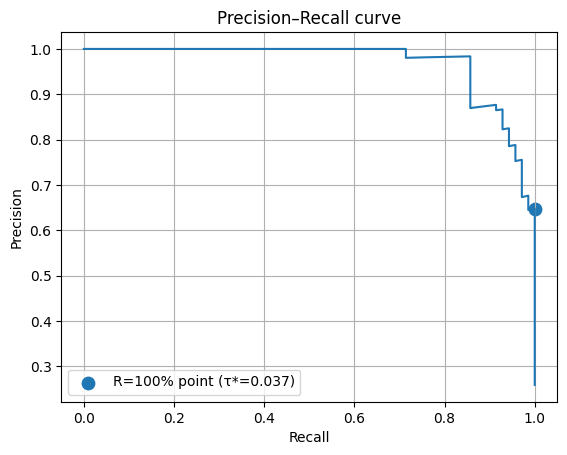

In [10]:
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

weight_path = "/content/best_model_vit.pt"  # .pt へのパス
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#学習時と同様にモデルを定義
model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
in_features = model.heads.head.in_features
#出力を2クラス用に置き換え
model.heads.head = nn.Linear(in_features, 2)
state = torch.load(weight_path, map_location=device)  # map_locationを指定
# 学習時に torch.save(model.state_dict()) で保存していればそのままOK
model.load_state_dict(state)
model.to(device)
model.eval


all_probs, all_labels, per_image_latencies = [], [], []

#評価データから確率と正解ラベルを収集＋レイテンシ測定
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        # GPU計測の前後で同期
        if device.type == "cuda":
            torch.cuda.synchronize()
        t0 = time.perf_counter()
        logits = model(imgs)                  # [バッチサイズ, クラス数]
        if device.type == "cuda":
            torch.cuda.synchronize()
        t1 = time.perf_counter()
        batch_time = t1 - t0
        per_image_latencies.extend([batch_time / imgs.size(0)] * imgs.size(0))

        probs = torch.softmax(logits, 1)      # [バッチサイズ, クラス数]
        all_probs.append(probs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

probs = np.concatenate(all_probs, axis=0)  # [評価データ数, クラス数]
y     = np.concatenate(all_labels, axis=0) # [評価データ数]


# class_to_idx: {'bad': 0, 'good': 1}
POSITIVE_LABEL = 0         # bad のラベルID
POSITIVE_IDX   = 0         # bad の確率列
y_true_bin = (y == POSITIVE_LABEL).astype(int)        # [評価データ数] 0/1
y_score    = probs[:, POSITIVE_IDX].astype(float)     # [評価データ数]

precision, recall, thr = precision_recall_curve(y_true_bin, y_score)

# Recall=100%を満たす運用閾値 τ* と P@R=100%
pos_scores = y_score[y_true_bin == 1]

tau_star = float(pos_scores.min())                 # 閾値：不良の最小スコア
y_pred_op = (y_score >= tau_star).astype(int)      # 1=不良で予測

TP = int(((y_pred_op == 1) & (y_true_bin == 1)).sum())
FP = int(((y_pred_op == 1) & (y_true_bin == 0)).sum())
TN = int(((y_pred_op == 0) & (y_true_bin == 0)).sum())
FN = int(((y_pred_op == 0) & (y_true_bin == 1)).sum())

recall_at_tau    = TP / (TP + FN) if (TP + FN) else 0.0
precision_at_tau = TP / (TP + FP) if (TP + FP) else 0.0

# レイテンシ統計
lat_ms = np.array(per_image_latencies) * 1000.0
p50 = np.percentile(lat_ms, 50)
p95 = np.percentile(lat_ms, 95)

print("=== 運用点(Recall=100%を満たす閾値) ===")
print(f"閾値 τ*                  : {tau_star:.6f}")
print(f"Recall@τ* (期待=1.0)     : {recall_at_tau:.4f}")
print(f"Precision@Recall=100%    : {precision_at_tau:.4f}")
print("\n=== 一枚当たりの推論時間 ===")
print(f"p50={p50:.2f} ms, p95={p95:.2f} ms")

# PRカーブ表示
plt.figure()
plt.plot(recall, precision, )
plt.scatter([1.0], [precision_at_tau], s=80, marker='o',
            label=f'R=100% point (τ*={tau_star:.3f})')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision–Recall curve')
plt.grid(True); plt.legend(); plt.show()